# Patient Segmentation using MIMIC-IV 

Dataset: MIMIC-IV Demo
Objective: Patient segmentation using demographic and admission features.


**MIMIC-IV (Clinical + Patient Behavior)**

#Data Source: PhysioNet

#Type: Hospital patient records (de-identified)

## What you get

Patient demographics

Admissions & readmissions

Diagnoses, procedures

Length of stay

Visit frequency (retention proxy)

## Perfect for

Patient segmentation

Readmission = churn proxy

High-risk vs loyal patients

## DEFINE THE SEGMENTATION AXES 

Your segments should answer:

A. Engagement

How often does the patient interact with care?

Do they return regularly?

B. Clinical Complexity

How sick / chronic is the patient?

Multiple diagnoses vs single episode

C. Care Intensity

ICU exposure

Transfers between units


## Environment Setup (Required for Windows)

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'


## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


## Load Data

In [3]:
patients = pd.read_csv('patients.csv')
admissions = pd.read_csv('admissions.csv')

df = admissions.merge(patients, on='subject_id', how='left')
df.head()


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,marital_status,race,edregtime,edouttime,hospital_expire_flag,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10004235,24181354,2196-02-24 14:38:00,2196-03-04 14:02:00,NaN,URGENT,P03YMR,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Medicaid,...,SINGLE,BLACK/CAPE VERDEAN,2196-02-24 12:15:00,2196-02-24 17:07:00,0,M,47,2196,2014 - 2016,NaN
1,10009628,25926192,2153-09-17 17:08:00,2153-09-25 13:20:00,NaN,URGENT,P41R5N,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Medicaid,...,MARRIED,HISPANIC/LATINO - PUERTO RICAN,NaN,NaN,0,M,58,2153,2011 - 2013,NaN
2,10018081,23983182,2134-08-18 02:02:00,2134-08-23 19:35:00,NaN,URGENT,P233F6,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Medicare,...,MARRIED,WHITE,2134-08-17 16:24:00,2134-08-18 03:15:00,0,M,79,2133,2011 - 2013,2134-10-28
3,10006053,22942076,2111-11-13 23:39:00,2111-11-15 17:20:00,2111-11-15 17:20:00,URGENT,P38TI6,TRANSFER FROM HOSPITAL,DIED,Medicaid,...,NaN,UNKNOWN,NaN,NaN,1,M,52,2111,2014 - 2016,2111-11-15
4,10031404,21606243,2113-08-04 18:46:00,2113-08-06 20:57:00,NaN,URGENT,P07HDB,TRANSFER FROM HOSPITAL,HOME,Other,...,WIDOWED,WHITE,NaN,NaN,0,F,82,2113,2014 - 2016,NaN


## Feature Engineering

In [4]:
df['admittime'] = pd.to_datetime(df['admittime'])
df['dischtime'] = pd.to_datetime(df['dischtime'])

# MIMIC-IV compliant age
df['age'] = df['anchor_age']

# Length of Stay
df['los'] = (df['dischtime'] - df['admittime']).dt.days

features = df[['age', 'los', 'gender', 'admission_type']].dropna()
features.head()


,age,los,gender,admission_type
0,47,8,M,URGENT
1,58,7,M,URGENT
2,79,5,M,URGENT
3,52,1,M,URGENT
4,82,2,F,URGENT


## Data Preprocessing

In [5]:
numeric_features = ['age', 'los']
categorical_features = ['gender', 'admission_type']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X = preprocessor.fit_transform(features)


## Silhouette Analysis

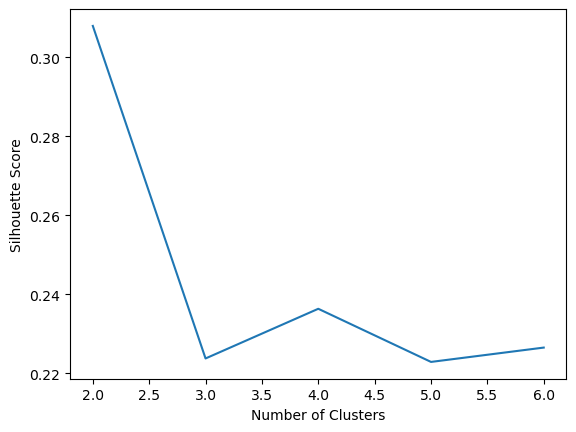

In [6]:
sil = []
K = range(2, 7)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    sil.append(silhouette_score(X, labels))

plt.plot(K, sil)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


## Final Model

In [7]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
features['cluster'] = kmeans.fit_predict(X)
features.head()


,age,los,gender,admission_type,cluster
0,47,8,M,URGENT,0
1,58,7,M,URGENT,0
2,79,5,M,URGENT,2
3,52,1,M,URGENT,0
4,82,2,F,URGENT,2


## Cluster Summary

In [8]:
features.groupby('cluster')[['age', 'los']].mean()


,age,los
cluster,,
0,52.210884,3.789116
1,58.727273,20.848485
2,75.515789,5.210526


## Conclusion
- Three distinct patient clusters were identified.
- Segmentation is driven by age and length of stay.
- Results can assist healthcare analytics and decision-making.
